# DO BASIS CHANGE (for Pyxaid users)

This file demonstrates how to convert the Hvib files (vibronic Hamiltonians in the KS basis) generated in the step2 to vibronic Hamiltonian files in the basis of configuration interaction (CI) functions composed of Slater Determinants (SD).

This example is specifically taylored to Pyxaid users, since they don't have transition density matrices or overlaps from the step2 of Pyxaid, only the Hvib. So, we need to use an alternative approach.

To start, lets import the required modules

In [1]:
import os
import sys

# Fisrt, we add the location of the library to test to the PYTHON path
if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
    

from libra_py import hpc_utils
from libra_py import data_read
from libra_py import data_outs
from libra_py import data_conv
from libra_py import units
from libra_py import QE_methods
from libra_py.workflows.nbra import step3
#import libra_py.workflows.nbra.step2_analysis as step2a

#import numpy as np
#from matplotlib.mlab import griddata

import matplotlib.pyplot as plt   # plots
%matplotlib inline 

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

/home/alexey/miniconda2/envs/libra/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: to-Python converter for std::vector<std::complex<double>, std::allocator<std::complex<double> > > already registered; second conversion method ignored.
  
/home/alexey/miniconda2/envs/libra/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  
/home/alexey/miniconda2/envs/libra/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator

Lets read in the files

In my case, the files contain 40 x 40 matrices, which are composed of 20 x 20 blocks of alpha and beta orbitals.

In this set of spin-orbitals, the orbital with index 28 is the alpha-HOMO. 

Assume we only need HOMO, LUMO, and LUMO+1 alpha-spin orbitals, so we can define this by setting the "active_space" parameter to the list \[28, 29, 30\]


In [2]:
params = { "data_set_paths" : [os.getcwd()+"/traj1_in/"],
           "data_dim":40, "active_space":[28, 29, 30],
           "isnap":0,  "fsnap":10,         
           "data_re_prefix" : "hvib_dia_", "data_re_suffix" : "_re",
           "data_im_prefix" : "hvib_dia_", "data_im_suffix" : "_im"  } 
Hvib_ks = data_read.get_data_sets(params)

Prepare the folder for the final results

In [3]:
# Remove the previous results and temporary working directory from the previous runs
os.system("rm -r traj1_out_pyxaid")

# Create the new results directory
os.system("mkdir traj1_out_pyxaid")

0

How, the KS orbitals are re-indexed as:

* 28 (H) -> 1
* 29 (L) -> 2
* 30 (L+1) -> 3

We can use the usual Pyxaid notation.

So we have 4 SD states:

* GS = \[1,-1\]
* S1 = \[1,-2\]
* S2 = \[1,-3\]
* T2 = \[1, 3\]

One can observe that 
* <GS|d/dt|S1> = <H|d/dt|L>
* <GS|d/dt|S2> = <H|d/dt|L+1>
* <S1|d/dt|S2> = <L|d/dt|L+1>
* <T2|d/dt|*> = 0

In [4]:
params1 = { "SD_basis" : [ [1, -1], [1, -2], [1, -3], [1, 3] ],
           "SD_energy_corr" : [0.0, 0.0, 0.0, 0.0],
           "CI_basis" : [ [1.0, 0.0, 0.0, 0.0],
                          [0.0, 1.0, 0.0, 0.0],
                          [0.0, 0.0, 1.0, 0.0],
                          [0.0, 0.0, 0.0, 1.0],
                        ],
          "output_set_paths" : [os.getcwd()+"/traj1_out_pyxaid/"], 
          "do_output" : 1,
          "Hvib_re_prefix":"Hvib_",  "Hvib_re_suffix":"_re",
          "Hvib_im_prefix":"Hvib_",  "Hvib_im_suffix":"_im"
         }

Hvib = step3.pyxaid2libra(Hvib_ks, params1)

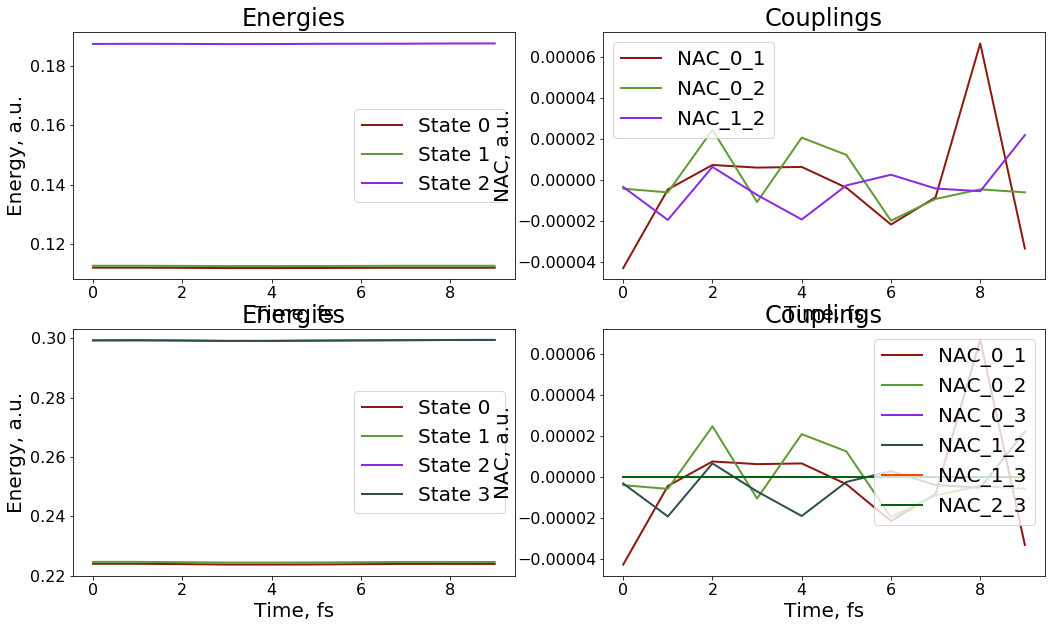

In [5]:
T = []
nsteps = params["fsnap"] - params["isnap"] 

for i in xrange(nsteps):
    T.append(i)

states = [0, 1, 2]    
nst = len(states)


plt.figure(1, figsize=(18, 10)) # dpi=300, frameon=False)
plt.subplot(2,2,1)
plt.title('Energies')
plt.xlabel('Time, fs')
plt.ylabel('Energy, a.u.')
for i in xrange(nst):
    st = states[i]
    En = data_conv.unpack1(Hvib_ks[0], st, st, 0)    
    plt.plot(T, En, label='State %i ' % (st), linewidth=2, color = colors[clrs_index[i]]) 
plt.legend()


plt.subplot(2,2,2)
plt.title('Couplings')
plt.xlabel('Time, fs')
plt.ylabel('NAC, a.u.')
cnt = 0
for i in xrange(nst):
    st1 = states[i]
    for j in xrange(i+1, nst):
        st2 = states[j]        
        NAC = data_conv.unpack1(Hvib_ks[0], st1, st2, 1)
        plt.plot(T, NAC, label='NAC_%i_%i' % (st1, st2), linewidth=2, color = colors[clrs_index[cnt]]) 
        cnt = cnt + 1
plt.legend()


states = [0, 1, 2, 3]    
nst = len(states)


plt.subplot(2,2,3)
plt.title('Energies')
plt.xlabel('Time, fs')
plt.ylabel('Energy, a.u.')
for i in xrange(nst):
    st = states[i]
    En = data_conv.unpack1(Hvib[0], st, st, 0)    
    plt.plot(T, En, label='State %i ' % (st), linewidth=2, color = colors[clrs_index[i]]) 
plt.legend()


plt.subplot(2,2,4)
plt.title('Couplings')
plt.xlabel('Time, fs')
plt.ylabel('NAC, a.u.')
cnt = 0
for i in xrange(nst):
    st1 = states[i]
    for j in xrange(i+1, nst):
        st2 = states[j]        
        NAC = data_conv.unpack1(Hvib[0], st1, st2, 1)
        plt.plot(T, NAC, label='NAC_%i_%i' % (st1, st2), linewidth=2, color = colors[clrs_index[cnt]]) 
        cnt = cnt + 1
plt.legend()



plt.show()
plt.close()

Lets text double excitations:

How, the KS orbitals are re-indexed as:

* 28 (H) -> 1
* 29 (L) -> 2
* 30 (L+1) -> 3

We can use the usual Pyxaid notation.

So we have 4 SD states:

* GS = \[1,-1\]
* D1 = \[2,-3\]
* D2 = \[3,-3\]

Note, it doesn't matter if the states are defined as any permutations of the indices, e.g.:

* GS = \[1,-1\]
* D1 = \[-3,-2\]
* D2 = \[-3,3\]


One can observe that 
* <GS|d/dt|D1> = 0
* <GS|d/dt|D2> = 0
* <D1|d/dt|D2> = <L|d/dt|L+1>

In [10]:
params2 = { "SD_basis" : [ [1, -1], [2, -3], [3, -3] ],
           "SD_energy_corr" : [0.0, 0.0, 0.0],
           "CI_basis" : [ [1.0, 0.0, 0.0],
                          [0.0, 1.0, 0.0],
                          [0.0, 0.0, 1.0]
                        ],
          "output_set_paths" : [os.getcwd()+"/traj1_out_pyxaid/"], 
          "do_output" : 1,
          "Hvib_re_prefix":"set2_Hvib_",  "Hvib_re_suffix":"_re",
          "Hvib_im_prefix":"set2_Hvib_",  "Hvib_im_suffix":"_im"
         }

Hvib2 = step3.pyxaid2libra(Hvib_ks, params2)

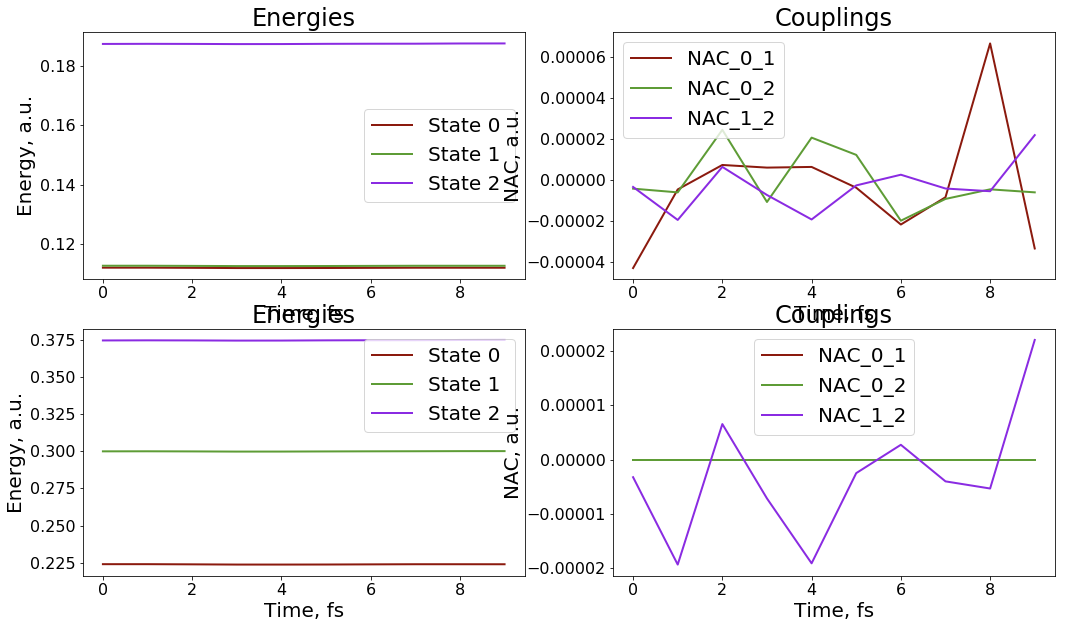

In [11]:
states = [0, 1, 2]    
nst = len(states)


plt.figure(1, figsize=(18, 10)) # dpi=300, frameon=False)
plt.subplot(2,2,1)
plt.title('Energies')
plt.xlabel('Time, fs')
plt.ylabel('Energy, a.u.')
for i in xrange(nst):
    st = states[i]
    En = data_conv.unpack1(Hvib_ks[0], st, st, 0)    
    plt.plot(T, En, label='State %i ' % (st), linewidth=2, color = colors[clrs_index[i]]) 
plt.legend()


plt.subplot(2,2,2)
plt.title('Couplings')
plt.xlabel('Time, fs')
plt.ylabel('NAC, a.u.')
cnt = 0
for i in xrange(nst):
    st1 = states[i]
    for j in xrange(i+1, nst):
        st2 = states[j]        
        NAC = data_conv.unpack1(Hvib_ks[0], st1, st2, 1)
        plt.plot(T, NAC, label='NAC_%i_%i' % (st1, st2), linewidth=2, color = colors[clrs_index[cnt]]) 
        cnt = cnt + 1
plt.legend()


states = [0, 1, 2]    
nst = len(states)


plt.subplot(2,2,3)
plt.title('Energies')
plt.xlabel('Time, fs')
plt.ylabel('Energy, a.u.')
for i in xrange(nst):
    st = states[i]
    En = data_conv.unpack1(Hvib2[0], st, st, 0)    
    plt.plot(T, En, label='State %i ' % (st), linewidth=2, color = colors[clrs_index[i]]) 
plt.legend()


plt.subplot(2,2,4)
plt.title('Couplings')
plt.xlabel('Time, fs')
plt.ylabel('NAC, a.u.')
cnt = 0
for i in xrange(nst):
    st1 = states[i]
    for j in xrange(i+1, nst):
        st2 = states[j]        
        NAC = data_conv.unpack1(Hvib2[0], st1, st2, 1)
        plt.plot(T, NAC, label='NAC_%i_%i' % (st1, st2), linewidth=2, color = colors[clrs_index[cnt]]) 
        cnt = cnt + 1
plt.legend()



plt.show()
plt.close()